In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix


In [2]:
path_to_query_adata = '/mnt/sata3/Dhruv_Analysis_1/2025_05_22_IL-15_KO/combined/final_with_resolvi_layer.h5ad'
query_adata = sc.read(path_to_query_adata)

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
import sys
sys.path.insert(0, '/home/amonell/piloting/scvi-tools/src')
print("Added to path:", sys.path[0])

import scvi.external.resolvi as RESOLVI
import scvi
print("Importing from:", scvi.external.resolvi.__file__)

Added to path: /home/amonell/piloting/scvi-tools/src
Importing from: /home/amonell/piloting/scvi-tools/src/scvi/external/resolvi/__init__.py


In [4]:

RESOLVI.RESOLVI.setup_anndata(
    query_adata, 
    labels_key="Subtype",
    layer="counts",
    batch_key="batch", 
    perturbation_key='mapped_batch', 
    control_perturbation='B6, IgG',
    background_key=None
)

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [5]:
supervised_resolvi = RESOLVI.RESOLVI(
    query_adata, semisupervised=True, n_latent = 32, perturbation_hidden_dim=128
)

# supervised_resolvi = RESOLVI.RESOLVI(
#     query_adata, semisupervised=True, mixture_k = 13,
#      n_latent=50,              # Higher latent dims
#     n_hidden=128,             # Increase from 32 (decoder)
#     n_hidden_encoder=256,     # Increase from 128 (encoder) 
#    override_mixture_k_in_semisupervised=False
#)

In [6]:


priors = supervised_resolvi.compute_dataset_dependent_priors()
print(priors)


{'background_ratio': 0.000708249, 'median_distance': 876.3375244140625, 'mean_log_counts': 5.2040067, 'std_log_counts': 0.9037821}


In [7]:
supervised_resolvi.module.guide.downsample_counts_mean = float(
    supervised_resolvi.module.guide.downsample_counts_mean
)
supervised_resolvi.module.guide.downsample_counts_std = float(
    supervised_resolvi.module.guide.downsample_counts_std
)
supervised_resolvi.train(
    max_epochs=100,
    check_val_every_n_epoch=100,
    lr=3e-4,
    train_on_perturbed_only=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training configuration with train_on_perturbed_only=True:
  Training set: 465653 perturbation-relevant cells (100.0%)
    - Control cells: 267436 (57.4%)
    - Perturbed cells: 198217 (42.6%)
  Background/neighbor computations: all 465653 cells


/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


In [ ]:
supervised_resolvi.save('arrayed_model.model')

In [ ]:
query_adata.write('arrayed_model.model/query_adata.h5ad')

In [ ]:
query_adata =  sc.read('arrayed_model.model/query_adata.h5ad')

In [ ]:
supervised_resolvi = RESOLVI.RESOLVI.load('arrayed_model.model',query_adata)

INFO     File perturb_model.model/model.pt already downloaded                                                      


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [8]:
query_adata.obs['p14_status']

query_nfkimjbc-1    Neither
query_jkkejebp-1    Neither
query_ohkbhjkp-1    Neither
query_ebbemcce-1    Neither
query_knpdcdjn-1    Neither
                     ...   
query_jcpkglfg-1    Neither
query_ilieepmn-1    Neither
query_ahfaibei-1    Neither
query_lcdpgioe-1    Neither
query_dnfejnfn-1    Neither
Name: p14_status, Length: 465653, dtype: category
Categories (3, object): ['Endogenous', 'Neither', 'P14']

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 5239 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


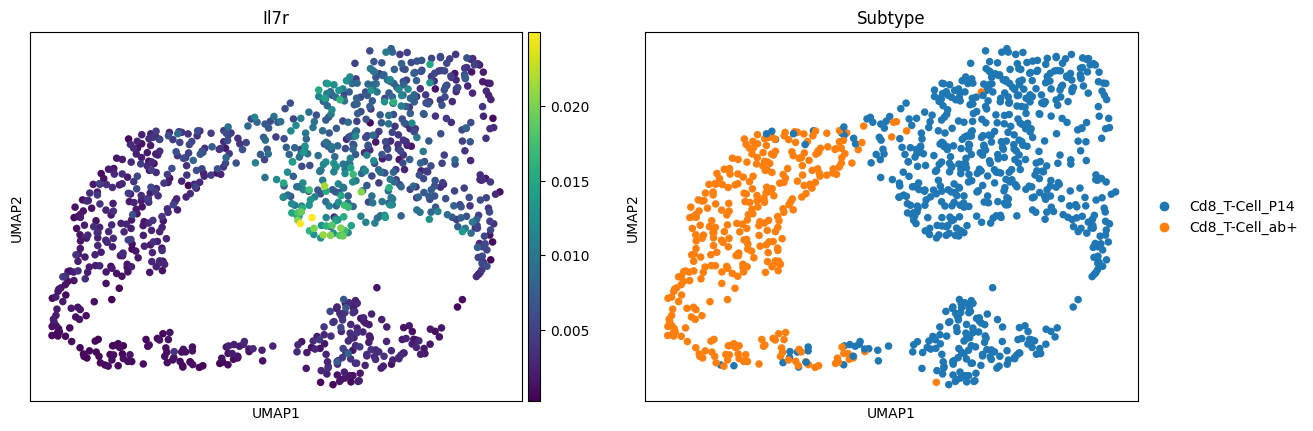

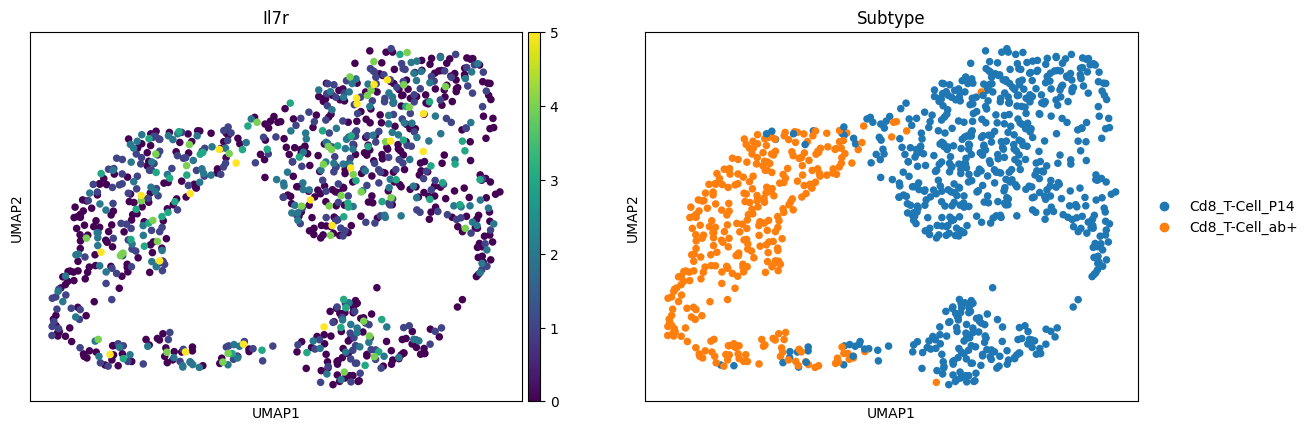

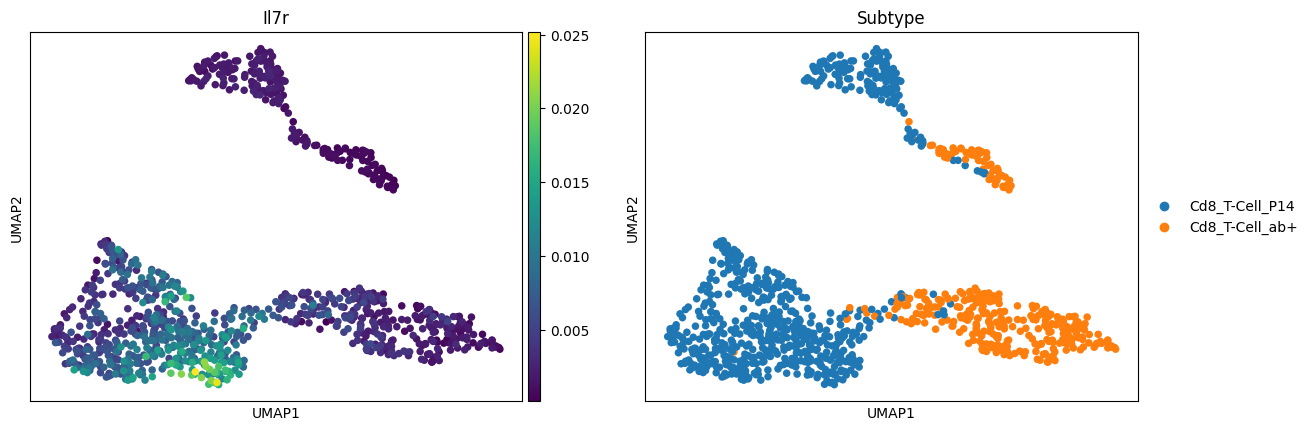

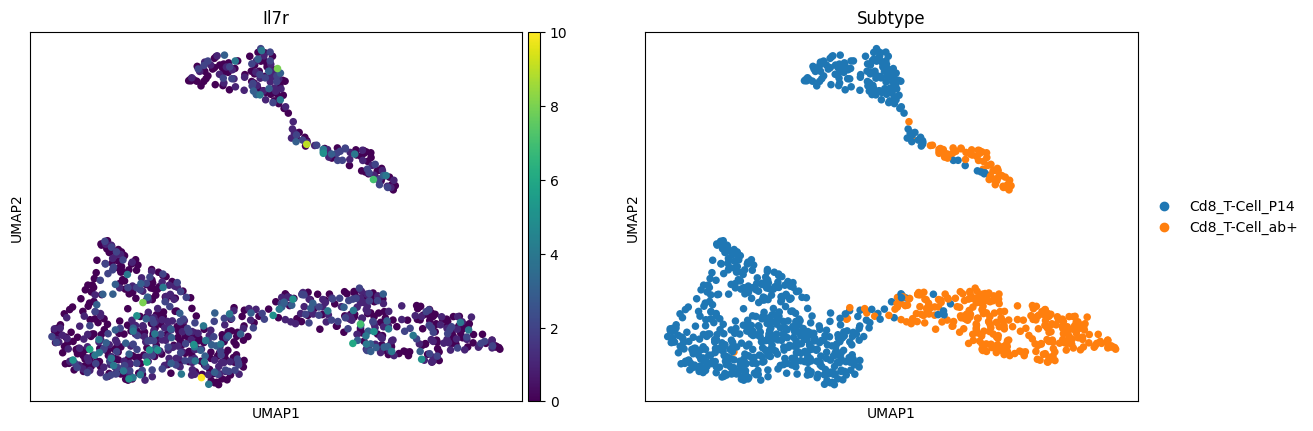

In [31]:
mini_adata = query_adata[query_adata.obs['p14_status'] == 'P14']
# Get denoised expression assuming control (no perturbations)
control_expr = supervised_resolvi.get_denoised_expression_control(mini_adata)

mini_adata.layers['resolvi_expression_no_shift'] = control_expr.values

sc.tl.pca(mini_adata, layer='resolvi_expression_no_shift')
sc.pp.neighbors(mini_adata)
sc.tl.umap(mini_adata)
sc.pl.umap(mini_adata, color=['Il7r', "Subtype"], layer='resolvi_expression_no_shift', ncols=2)
sc.pl.umap(mini_adata, color=['Il7r', "Subtype"], ncols=2, vmax=5)

perturbed_expr = supervised_resolvi.get_denoised_expression_perturbed(mini_adata)

mini_adata.layers['resolvi_expression_with_shift'] = perturbed_expr.values

sc.tl.pca(mini_adata, layer='resolvi_expression_with_shift')
sc.pp.neighbors(mini_adata)
sc.tl.umap(mini_adata)
sc.pl.umap(mini_adata, color=['Il7r', "Subtype"], layer='resolvi_expression_with_shift', ncols=2)
sc.pl.umap(mini_adata, color=['Il7r', "Subtype"], ncols=2)




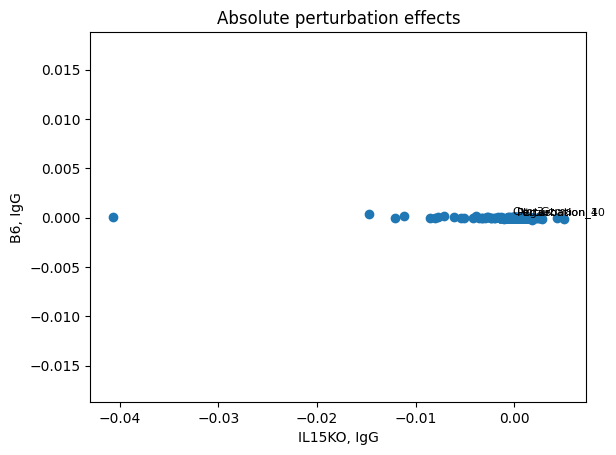

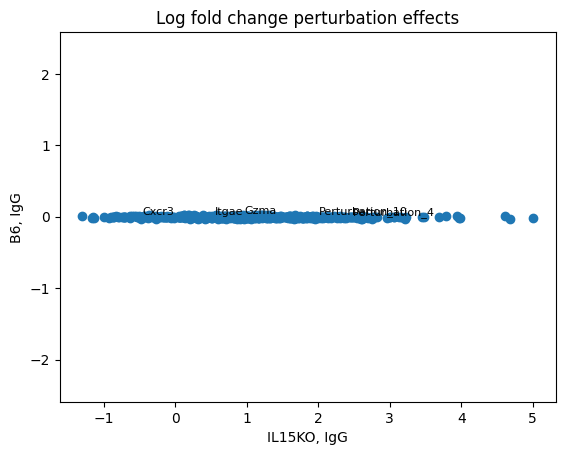

In [10]:

mini_adata.layers['absolute_perturbation_effects'] = perturbed_expr - control_expr

log_fold_change = np.log2(perturbed_expr + 1e-8) - np.log2(control_expr + 1e-8)

batch1_counts = mini_adata[mini_adata.obs['mapped_batch'] == 'IL15KO, IgG'].layers['absolute_perturbation_effects'].mean(axis=0)
batch2_counts = mini_adata[mini_adata.obs['mapped_batch'] == 'B6, IgG'].layers['absolute_perturbation_effects'].mean(axis=0)
plt.scatter(batch1_counts, batch2_counts)
plt.axis('equal')
# Annotate specific points only
genes_to_annotate = ['Cxcr3', 'Gzma', 'Itgae', 'Perturbation_10', 'Perturbation_4']
for i, gene_name in enumerate(mini_adata.var.index):
    if gene_name in genes_to_annotate:
        plt.annotate(gene_name, (batch1_counts[i], batch2_counts[i]), 
                    textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)
plt.xlabel('IL15KO, IgG')
plt.ylabel('B6, IgG')
plt.title('Absolute perturbation effects')
plt.show()

mini_adata.layers['log_fold_change'] = log_fold_change
batch1_counts = mini_adata[mini_adata.obs['mapped_batch'] == 'IL15KO, IgG'].layers['log_fold_change'].mean(axis=0)
batch2_counts = mini_adata[mini_adata.obs['mapped_batch'] == 'B6, IgG'].layers['log_fold_change'].mean(axis=0)
plt.scatter(batch1_counts, batch2_counts)
plt.axis('equal')
# Annotate specific points only
genes_to_annotate = ['Cxcr3', 'Gzma', 'Itgae', 'Perturbation_10', 'Perturbation_4']
for i, gene_name in enumerate(mini_adata.var.index):
    if gene_name in genes_to_annotate:
        plt.annotate(gene_name, (batch1_counts[i], batch2_counts[i]), 
                    textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)
plt.xlabel('IL15KO, IgG')
plt.ylabel('B6, IgG')
plt.title('Log fold change perturbation effects')
plt.show()

/tmp/ipykernel_3164161/332096473.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(gene_name, (IL15KO_IgG_mean_expr[i], IL15KO_IgG_absolute[i]),


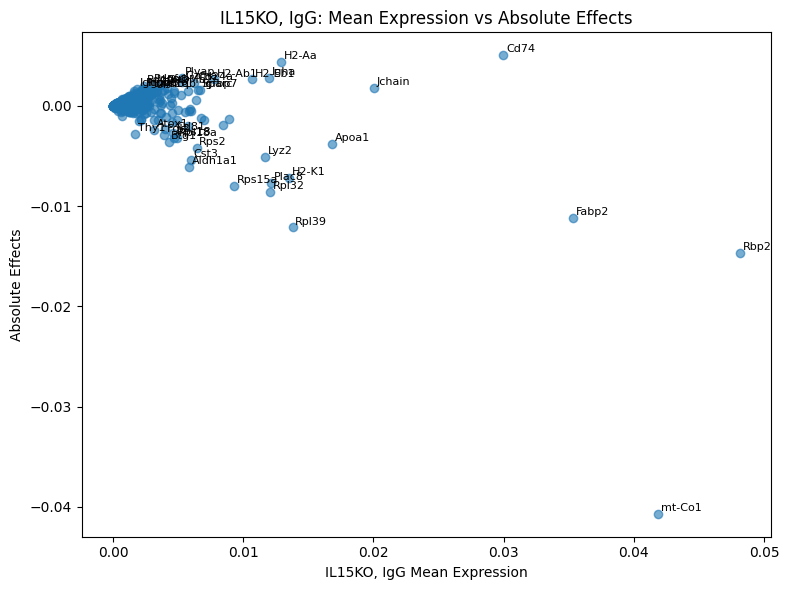

/tmp/ipykernel_3164161/332096473.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(gene_name, (IL15KO_IgG_mean_expr[i], IL15KO_IgG_log_fold[i]),


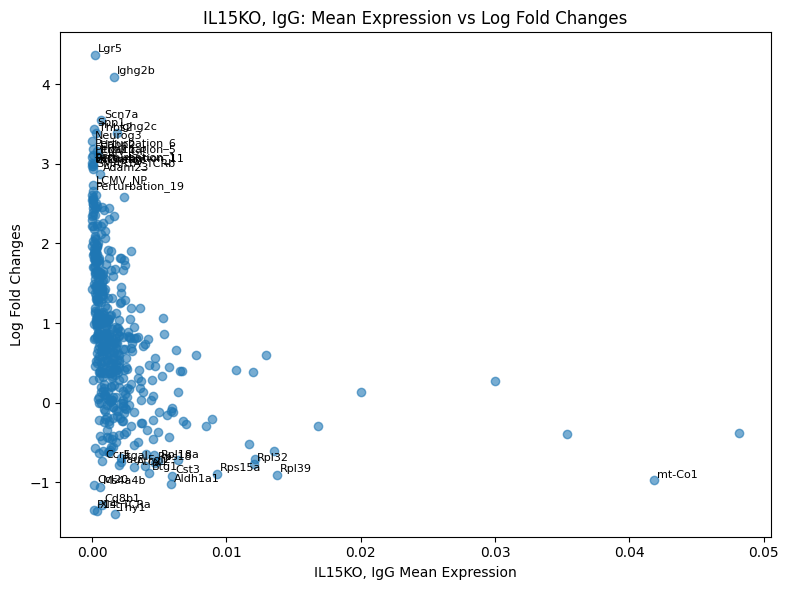

In [30]:
# Get IL15KO, IgG mean expression from perturbed_expr
IL15KO_IgG_mean_expr = perturbed_expr[mini_adata.obs['mapped_batch'] == 'IL15KO, IgG'].mean(axis=0)

# Calculate absolute effects
absolute_effects = perturbed_expr - control_expr

# Get IL15KO, IgG effects
IL15KO_IgG_absolute = absolute_effects[mini_adata.obs['mapped_batch'] == 'IL15KO, IgG'].mean(axis=0)

# Plot absolute effects vs mean expression
plt.figure(figsize=(8, 6))
plt.scatter(IL15KO_IgG_mean_expr, IL15KO_IgG_absolute, alpha=0.6)

# Get top and bottom points for absolute effects
abs_top_indices = np.argsort(IL15KO_IgG_absolute)[-20:]  # Top 20
abs_bottom_indices = np.argsort(IL15KO_IgG_absolute)[:20]  # Bottom 20
abs_annotate_indices = np.concatenate([abs_top_indices, abs_bottom_indices])

for i in abs_annotate_indices:
    gene_name = mini_adata.var.index[i]
    plt.annotate(gene_name, (IL15KO_IgG_mean_expr[i], IL15KO_IgG_absolute[i]), 
                textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)
plt.xlabel('IL15KO, IgG Mean Expression')
plt.ylabel('Absolute Effects')
plt.title('IL15KO, IgG: Mean Expression vs Absolute Effects')

plt.tight_layout()
plt.show()
# Get IL15KO, IgG mean expression (already in your code)
IL15KO_IgG_mean_expr = perturbed_expr[mini_adata.obs['mapped_batch'] == 'IL15KO, IgG'].mean(axis=0)
control_mean_expr = control_expr[mini_adata.obs['mapped_batch'] == 'IL15KO, IgG'].mean(axis=0)

# Calculate log fold changes properly: log2 of ratio of means
# Assuming control_expr is already the per-gene mean control expression
IL15KO_IgG_log_fold = np.log2((IL15KO_IgG_mean_expr + 1e-8) / (control_mean_expr + 1e-8))

# Plot log fold changes vs mean expression
plt.figure(figsize=(8, 6))
plt.scatter(IL15KO_IgG_mean_expr, IL15KO_IgG_log_fold, alpha=0.6)

# Get top and bottom points for log fold changes
lfc_top_indices = np.argsort(IL15KO_IgG_log_fold)[-20:]  # Top 20
lfc_bottom_indices = np.argsort(IL15KO_IgG_log_fold)[:20]  # Bottom 20
lfc_annotate_indices = np.concatenate([lfc_top_indices, lfc_bottom_indices])

for i in lfc_annotate_indices:
    gene_name = mini_adata.var.index[i]
    plt.annotate(gene_name, (IL15KO_IgG_mean_expr[i], IL15KO_IgG_log_fold[i]), 
                 textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)
plt.xlabel('IL15KO, IgG Mean Expression')
plt.ylabel('Log Fold Changes')
plt.title('IL15KO, IgG: Mean Expression vs Log Fold Changes')

plt.tight_layout()
plt.show()

In [32]:
IL15KO_IgG_absolute.loc[['Cxcr3', 'Itgae', 'Mki67', 'Klf2', 'Gzma', 'Il7r', 'Il15ra', 'Il21r', 'Ifng', 'Tgfbr2', 'Il18rap', 'Cxcl9', 'Srebf2', 'Aldh1a1', 'Il2ra', 'Irf8', 'Cd69', 'Gzmb']]

Cxcr3     -0.000418
Itgae      0.000654
Mki67      0.000670
Klf2      -0.000224
Gzma       0.002395
Il7r      -0.000561
Il15ra     0.000104
Il21r      0.000111
Ifng       0.000305
Tgfbr2     0.000127
Il18rap    0.000279
Cxcl9      0.000975
Srebf2    -0.001127
Aldh1a1   -0.006090
Il2ra      0.000196
Irf8       0.001756
Cd69       0.000278
Gzmb       0.001419
dtype: float32